# **Simple RNN**

Se predice solo el siguiente punto de la serie de tiempo, luego esta predicción se agrega al final de la serie y se predice el punto $i+1$, esto se hace repetidamemente hasta que se prediga el último punto de la serie. Esto se realiza con un entrenamiento del tipo rolling window, es decir, se entrena con un conjunto de datos y se predice el siguiente punto, luego se desliza la ventana de entrenamiento un paso y se vuelve a entrenar y predecir el siguiente punto.

El vector final de salida, será de largo $X$ donde se necesitaran $X$ predicciones previas para poder obtenerlo.

In [126]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from earlystop import EarlyStopper
from lstm_models import AirModel, StackLSTM
from RNN_model import Simple_RNN



#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils


np.random.seed(seed=77)
torch.manual_seed(77)

In [127]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file7_080124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.134180,0.023473,0.002203,0.002203-0.001490j,0.002659,-0.594742,-0.051439
1,0.135824,0.025117,0.002051,0.002051+0.000170j,0.002058,0.082612,-0.020024
2,0.136482,0.025775,0.001900,0.001900+0.000303j,0.001924,0.158163,0.009547
3,0.137797,0.027090,0.001749,0.001749+0.000903j,0.001969,0.476669,0.035605
4,0.137797,0.027090,0.001599,0.001599+0.000993j,0.001882,0.555726,0.056848


## **prepare data**

* Se puede eliminar el minmaxscaler

In [128]:
#data 

amplitudes = df['Amplitude'][300:50000].values
scale = MinMaxScaler(feature_range=(-1, 1))
amplitudes = scale.fit_transform(amplitudes.reshape(-1, 1))
#amplitudes = amplitudes.reshape(-1,1)
amplitudes.shape


In [129]:
def create_data(data, seq_len):
    N = len(data)
    X = []
    Y = []
    for i in range(N-seq_len-1):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len])
    
    return np.array(X), np.array(Y)

def split_data(x,y,ratio):
    assert len(x) == len(y)
    N = len(x)
    x_train, x_test = x[:int(N*ratio)], x[int(N*ratio):]
    y_train, y_test = y[:int(N*ratio)], y[int(N*ratio):]
    return x_train, y_train, x_test, y_test

In [130]:
x,y = create_data(amplitudes, 100)
x_train, y_train, x_test, y_test = split_data(x,y,0.7)

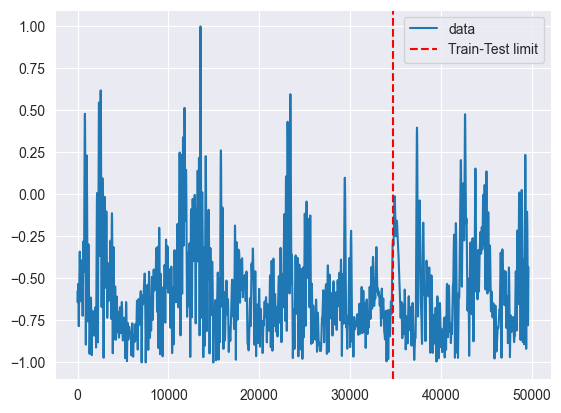

In [131]:
plt.plot(np.vstack((y_train,y_test)))
plt.axvline(int(len(x)*0.7), color = 'r', linestyle = '--')
plt.legend(['data', 'Train-Test limit'])
plt.show()

train, val = utils.split_data(amplitudes)
x_train, y_train = utils.create_dataset(train, window = 1000, horizon = 1000)
x_val, y_val = utils.create_dataset(val, window = 1000, horizon = 1000)
train_loader = utils.create_loader(x_train, y_train, 32)
val_loader = utils.create_loader(x_val, y_val, 32)

print(x_train.shape, y_train.shape ,x_val.shape, y_val.shape)

plt.plot(np.vstack((x_train[45],y_val[45])), label='Input')
#plt.plot(y_train[0], label='Target')
plt.axvline(x=len(x_train[0]), color='r', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Example of Training')
plt.show()


## **Simple RNN**

In [132]:

# Implement the RNN 
class Simple_RNN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        
        # define the dimensions
        self.in_dim = in_dim
        self.hid_dim = in_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        # define the rnn layer
        self.rnn = nn.RNN(self.in_dim, self.hid_dim, self.layer, nonlinearity='tanh', batch_first=True)
        
        # define fully connected layer for output
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        
        # initialize the hidden layer
        h0 = torch.zeros(self.layer, x.size(0),self.hid_dim)
        
        #initialize the rnn
        out, _ = self.rnn(x,h0)
        
        out = self.fc(out[:,-1,:])
        return out

#### **initialize model**

In [133]:
# data to tensor
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

x.shape, y.shape

((49599, 100, 1), (49599, 1))

In [146]:
def create_loader(X, y, batch_size=32, shuffle=True):
  loader = data_utils.DataLoader(data_utils.TensorDataset(X, y), shuffle = shuffle, batch_size = batch_size)
  return loader

In [147]:
train_loader = create_loader(x_train, y_train)
test_loader = create_loader(x_test, y_test)

In [134]:
#net

in_size = x.shape[-1]
out_size = in_size
hid_size = 3
num_layers = 1


model = Simple_RNN(in_size, hid_size, out_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.0001333830648308812, Test Loss: 5.797805164528194e-05
Epoch: 0, Loss: 8.98041544132866e-05


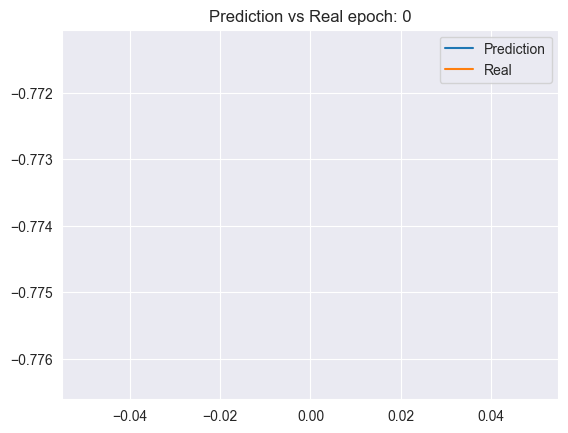

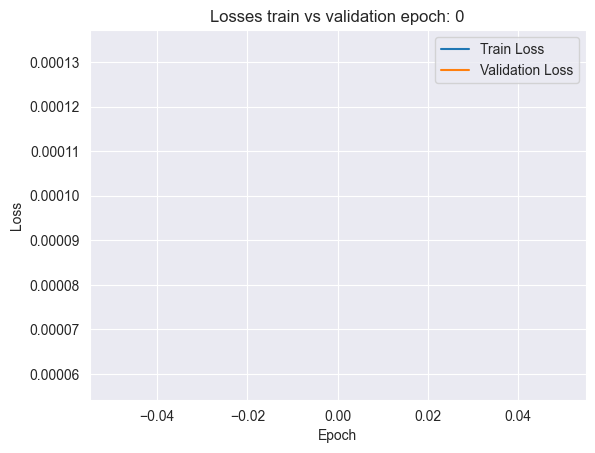

 10%|█         | 10/100 [03:13<28:19, 18.89s/it]

Epoch: 10, Train Loss: 2.142047052758382e-05, Test Loss: 2.932073715861426e-05
Epoch: 10, Loss: 1.6881436749827117e-05


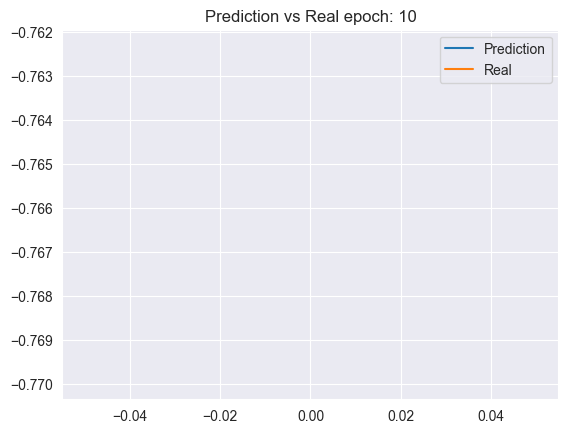

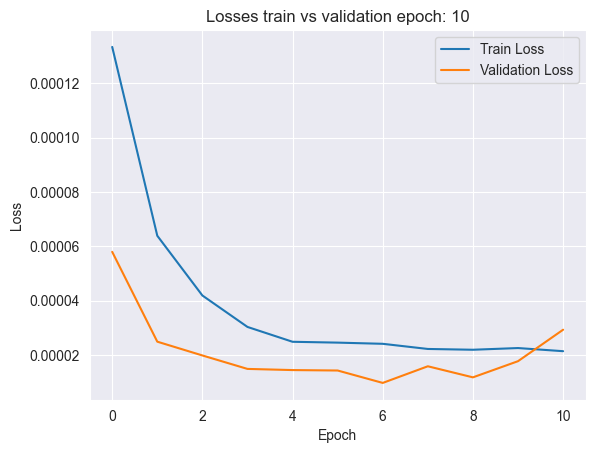

 12%|█▏        | 12/100 [03:52<28:04, 19.14s/it]

Early stopping, saving checkpoint of 11


 13%|█▎        | 13/100 [04:11<27:49, 19.19s/it]

Early stopping, saving checkpoint of 12


 15%|█▌        | 15/100 [04:50<27:35, 19.47s/it]

Early stopping, saving checkpoint of 14


 16%|█▌        | 16/100 [05:09<27:01, 19.30s/it]

Early stopping, saving checkpoint of 15


 17%|█▋        | 17/100 [05:29<26:51, 19.41s/it]

Early stopping, saving checkpoint of 16


 18%|█▊        | 18/100 [05:49<26:50, 19.64s/it]

Early stopping, saving checkpoint of 17


 19%|█▉        | 19/100 [06:09<26:44, 19.81s/it]

Early stopping, saving checkpoint of 18


 20%|██        | 20/100 [06:30<26:35, 19.94s/it]

Epoch: 20, Train Loss: 1.922492526155362e-05, Test Loss: 2.3582602011384718e-05
Epoch: 20, Loss: 1.316246016358491e-05


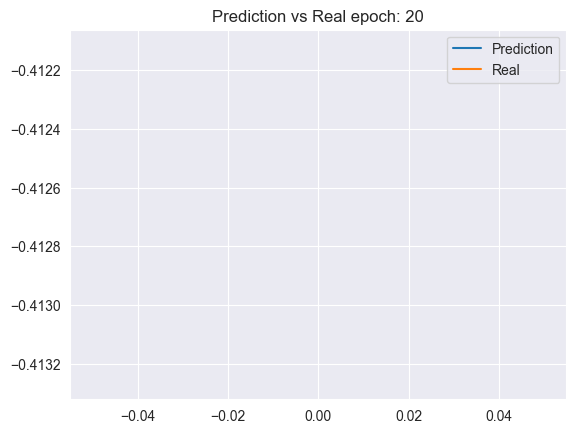

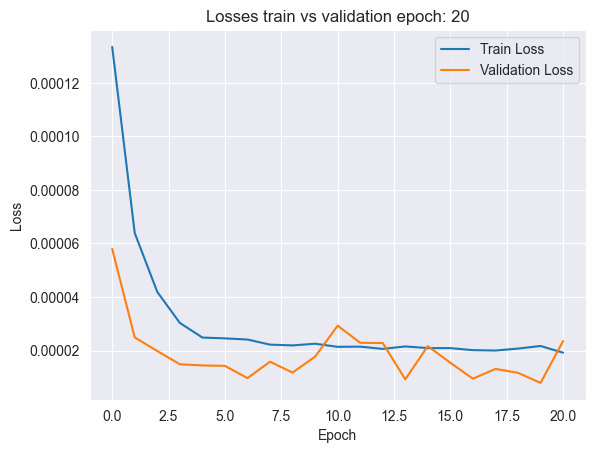

 21%|██        | 21/100 [06:50<26:24, 20.05s/it]

Early stopping, saving checkpoint of 20


 22%|██▏       | 22/100 [07:10<26:05, 20.07s/it]

Early stopping, saving checkpoint of 21


 23%|██▎       | 23/100 [07:30<25:45, 20.07s/it]

Early stopping, saving checkpoint of 22


 24%|██▍       | 24/100 [07:51<25:35, 20.21s/it]

Early stopping, saving checkpoint of 23


 25%|██▌       | 25/100 [08:10<25:04, 20.06s/it]

Early stopping, saving checkpoint of 24


 26%|██▌       | 26/100 [08:30<24:36, 19.95s/it]

Early stopping, saving checkpoint of 25


 27%|██▋       | 27/100 [08:49<24:03, 19.77s/it]

Early stopping, saving checkpoint of 26


 28%|██▊       | 28/100 [09:09<23:38, 19.70s/it]

Early stopping, saving checkpoint of 27


 29%|██▉       | 29/100 [09:28<23:06, 19.53s/it]

Early stopping, saving checkpoint of 28


 30%|███       | 30/100 [09:47<22:39, 19.42s/it]

Early stopping, saving checkpoint of 29
Epoch: 30, Train Loss: 2.0393715137879344e-05, Test Loss: 2.1927414579089776e-05
Epoch: 30, Loss: 9.977229638025165e-06


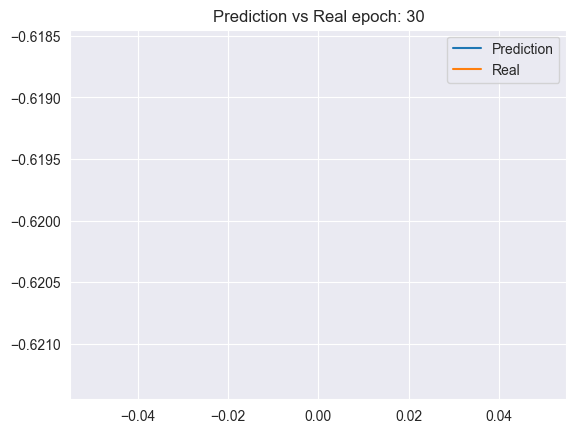

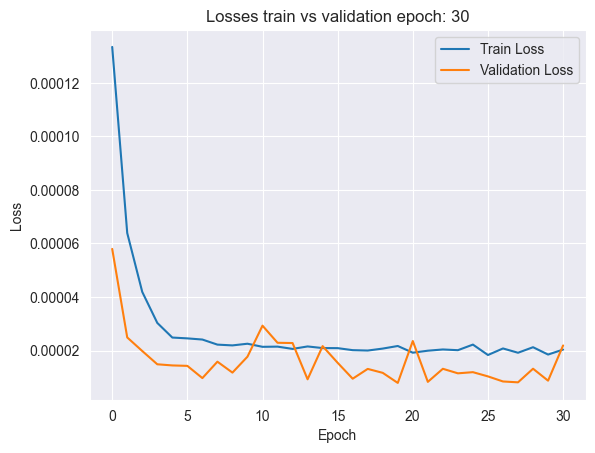

 31%|███       | 31/100 [10:07<22:22, 19.46s/it]

Early stopping, saving checkpoint of 30


 32%|███▏      | 32/100 [10:26<21:52, 19.31s/it]

Early stopping, saving checkpoint of 31


 33%|███▎      | 33/100 [10:45<21:29, 19.24s/it]

Early stopping, saving checkpoint of 32


 34%|███▍      | 34/100 [11:04<21:06, 19.19s/it]

Early stopping, saving checkpoint of 33


 35%|███▌      | 35/100 [11:23<20:46, 19.17s/it]

Early stopping, saving checkpoint of 34


 36%|███▌      | 36/100 [11:42<20:29, 19.21s/it]

Early stopping, saving checkpoint of 35


 37%|███▋      | 37/100 [12:01<20:09, 19.20s/it]

Early stopping, saving checkpoint of 36


 38%|███▊      | 38/100 [12:20<19:43, 19.09s/it]

Early stopping, saving checkpoint of 37


 39%|███▉      | 39/100 [12:39<19:24, 19.09s/it]

Early stopping, saving checkpoint of 38


 40%|████      | 40/100 [12:58<19:03, 19.05s/it]

Early stopping, saving checkpoint of 39
Epoch: 40, Train Loss: 2.0486049575691324e-05, Test Loss: 1.0396038231446773e-05
Epoch: 40, Loss: 1.0205576472799294e-05


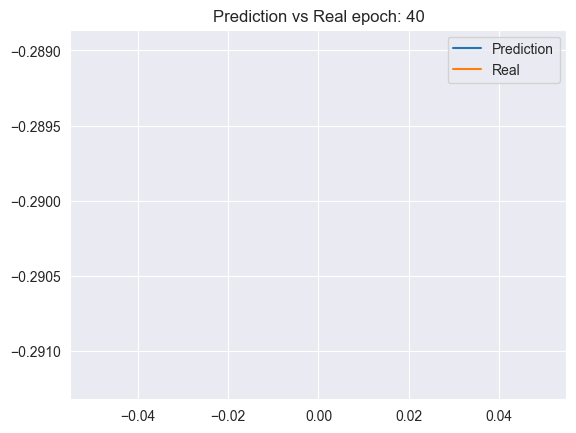

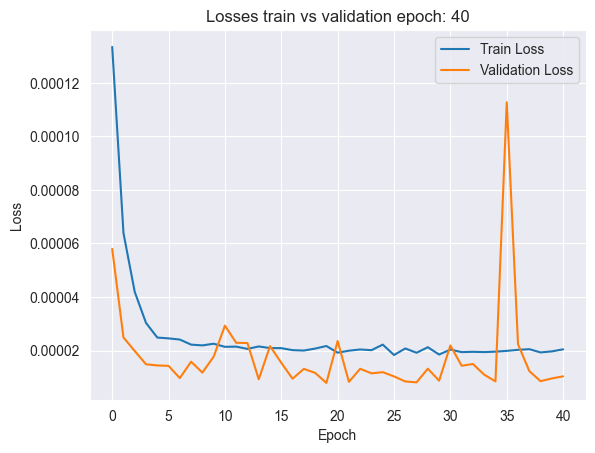

 41%|████      | 41/100 [13:18<18:55, 19.25s/it]

Early stopping, saving checkpoint of 40


 42%|████▏     | 42/100 [13:37<18:35, 19.23s/it]

Early stopping, saving checkpoint of 41


 43%|████▎     | 43/100 [13:56<18:12, 19.17s/it]

Early stopping, saving checkpoint of 42


 44%|████▍     | 44/100 [14:15<17:48, 19.08s/it]

Early stopping, saving checkpoint of 43


 45%|████▌     | 45/100 [14:34<17:32, 19.14s/it]

Early stopping, saving checkpoint of 44


 46%|████▌     | 46/100 [14:54<17:14, 19.17s/it]

Early stopping, saving checkpoint of 45


 47%|████▋     | 47/100 [15:13<16:57, 19.19s/it]

Early stopping, saving checkpoint of 46


 48%|████▊     | 48/100 [15:32<16:40, 19.24s/it]

Early stopping, saving checkpoint of 47


 49%|████▉     | 49/100 [15:52<16:22, 19.26s/it]

Early stopping, saving checkpoint of 48


 50%|█████     | 50/100 [16:11<16:03, 19.26s/it]

Early stopping, saving checkpoint of 49
Epoch: 50, Train Loss: 1.8778015524848373e-05, Test Loss: 1.9910410741118463e-05
Epoch: 50, Loss: 3.3246673410758376e-05


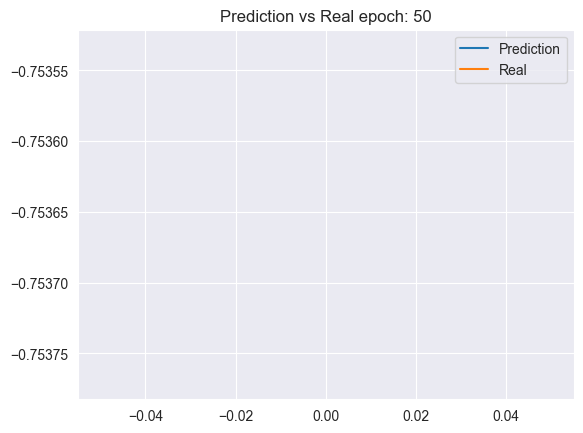

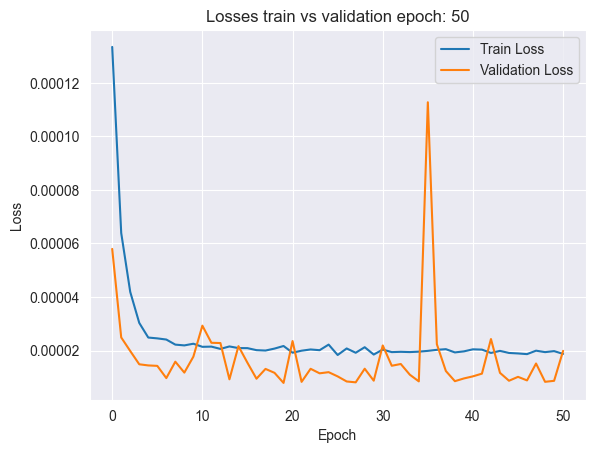

 51%|█████     | 51/100 [16:31<15:56, 19.52s/it]

Early stopping, saving checkpoint of 50


 52%|█████▏    | 52/100 [16:50<15:30, 19.39s/it]

Early stopping, saving checkpoint of 51


 54%|█████▍    | 54/100 [17:28<14:44, 19.22s/it]

Early stopping, saving checkpoint of 53


 56%|█████▌    | 56/100 [18:09<14:27, 19.72s/it]

Early stopping, saving checkpoint of 55


 57%|█████▋    | 57/100 [18:28<14:04, 19.63s/it]

Early stopping, saving checkpoint of 56


 58%|█████▊    | 58/100 [18:47<13:36, 19.43s/it]

Early stopping, saving checkpoint of 57


 59%|█████▉    | 59/100 [19:06<13:11, 19.30s/it]

Early stopping, saving checkpoint of 58


 60%|██████    | 60/100 [19:25<12:47, 19.19s/it]

Early stopping, saving checkpoint of 59
Epoch: 60, Train Loss: 2.000500242540033e-05, Test Loss: 1.1742318757344664e-05
Epoch: 60, Loss: 3.4323889849474654e-05


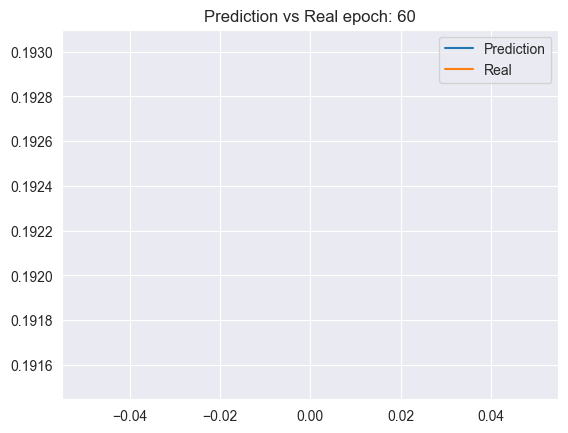

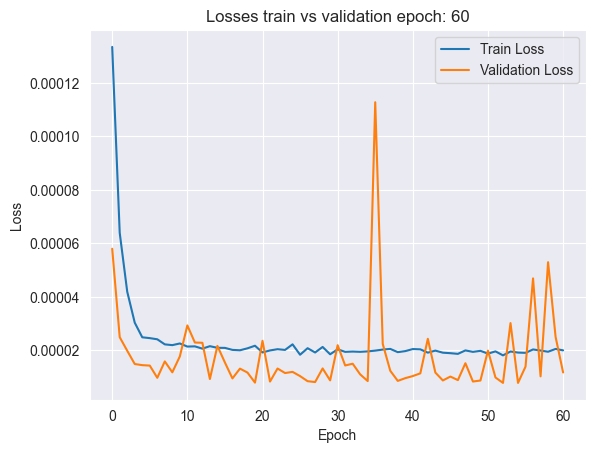

 61%|██████    | 61/100 [19:45<12:36, 19.40s/it]

Early stopping, saving checkpoint of 60


 62%|██████▏   | 62/100 [1:03:08<8:23:11, 794.51s/it]

Early stopping, saving checkpoint of 61


 63%|██████▎   | 63/100 [1:03:29<5:46:55, 562.58s/it]

Early stopping, saving checkpoint of 62


 64%|██████▍   | 64/100 [1:03:50<4:00:01, 400.05s/it]

Early stopping, saving checkpoint of 63


 65%|██████▌   | 65/100 [1:04:11<2:47:01, 286.34s/it]

Early stopping, saving checkpoint of 64


 65%|██████▌   | 65/100 [1:04:16<34:36, 59.33s/it]   


Training interrupted by user


In [148]:
#batch training
model, train_lossavg, test_lossavg = utils.train_model(model,
            optimizer,
            criterion,
            train_loader,
            test_loader,
            n_epochs = 100,
            ncheckpoint =10)

In [ ]:
#non batch training model
in_size = x.shape[-1]
out_size = in_size
hid_size = 3
num_layers = 1


model_nb = Simple_RNN(in_size, hid_size, out_size, num_layers)
optimizer = optim.Adam(model_nb.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [135]:
#non-batch training
def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in tqdm(range(epochs)):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred,y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        if (epoch+1) % 5 ==0:
            print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss

In [136]:
train_loss, test_loss = train_model(model_nb,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               epochs=100)

  6%|▌         | 6/100 [00:01<00:14,  6.35it/s]

Epoch :0.05    Train Loss :0.11724459379911423    Test Loss :0.12434377521276474


 11%|█         | 11/100 [00:01<00:13,  6.73it/s]

Epoch :0.1    Train Loss :0.10871747136116028    Test Loss :0.11367522925138474


 16%|█▌        | 16/100 [00:02<00:12,  6.92it/s]

Epoch :0.15    Train Loss :0.10186678171157837    Test Loss :0.10549832880496979


 21%|██        | 21/100 [00:03<00:11,  7.05it/s]

Epoch :0.2    Train Loss :0.0961868017911911    Test Loss :0.1001298725605011


 26%|██▌       | 26/100 [00:03<00:10,  7.03it/s]

Epoch :0.25    Train Loss :0.09160242974758148    Test Loss :0.09632372856140137


 31%|███       | 31/100 [00:04<00:10,  6.56it/s]

Epoch :0.3    Train Loss :0.08793190121650696    Test Loss :0.0923364982008934


 36%|███▌      | 36/100 [00:05<00:09,  6.85it/s]

Epoch :0.35    Train Loss :0.08491271734237671    Test Loss :0.08882763981819153


 41%|████      | 41/100 [00:06<00:08,  6.87it/s]

Epoch :0.4    Train Loss :0.0824536681175232    Test Loss :0.08634956926107407


 46%|████▌     | 46/100 [00:06<00:07,  7.16it/s]

Epoch :0.45    Train Loss :0.08034171164035797    Test Loss :0.08448908478021622


 51%|█████     | 51/100 [00:07<00:07,  6.47it/s]

Epoch :0.5    Train Loss :0.07852716743946075    Test Loss :0.08261673152446747


 56%|█████▌    | 56/100 [00:08<00:06,  7.30it/s]

Epoch :0.55    Train Loss :0.0768698900938034    Test Loss :0.0807347521185875


 61%|██████    | 61/100 [00:09<00:05,  7.23it/s]

Epoch :0.6    Train Loss :0.07530523836612701    Test Loss :0.07909942418336868


 66%|██████▌   | 66/100 [00:09<00:04,  7.20it/s]

Epoch :0.65    Train Loss :0.07373877614736557    Test Loss :0.07755644619464874


 71%|███████   | 71/100 [00:10<00:04,  7.05it/s]

Epoch :0.7    Train Loss :0.07210247218608856    Test Loss :0.07580671459436417


 76%|███████▌  | 76/100 [00:11<00:03,  7.08it/s]

Epoch :0.75    Train Loss :0.07031489163637161    Test Loss :0.07383084297180176


 81%|████████  | 81/100 [00:11<00:02,  6.64it/s]

Epoch :0.8    Train Loss :0.06830038875341415    Test Loss :0.07167953252792358


 86%|████████▌ | 86/100 [00:12<00:02,  6.70it/s]

Epoch :0.85    Train Loss :0.06597578525543213    Test Loss :0.06919391453266144


 91%|█████████ | 91/100 [00:13<00:01,  6.80it/s]

Epoch :0.9    Train Loss :0.06325068324804306    Test Loss :0.06620843708515167


 96%|█████████▌| 96/100 [00:14<00:00,  6.78it/s]

Epoch :0.95    Train Loss :0.060029298067092896    Test Loss :0.0626930296421051


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]

Epoch :1.0    Train Loss :0.05620817095041275    Test Loss :0.05854583904147148


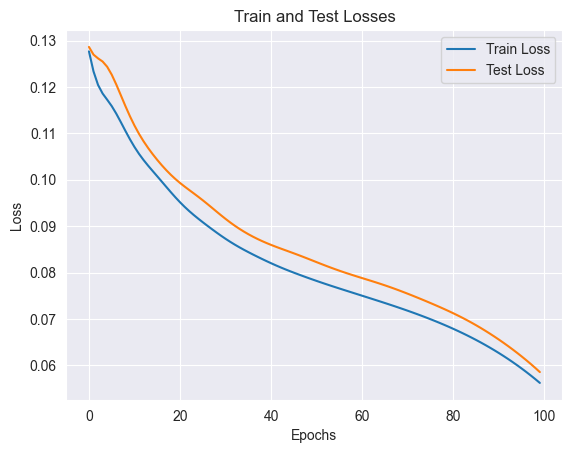

In [137]:

# Plot train and test losses
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()


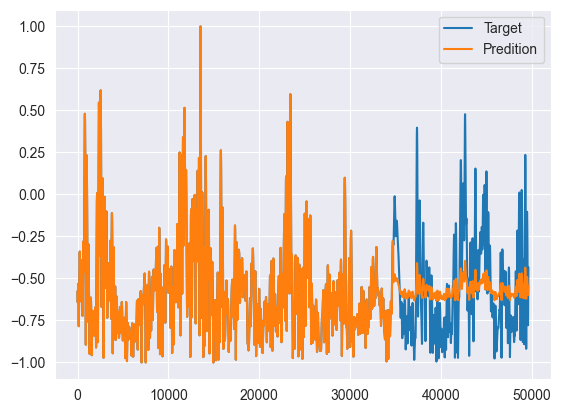

In [138]:
plt.plot(np.vstack((y_train.detach().numpy(),y_test.detach().numpy())),label='Target') 
plt.plot(np.vstack((y_train.detach().numpy(),model(x_test).detach().numpy())),label='Predition') 
#plt.axvline(int(len(x)*0.8)) 
plt.legend()

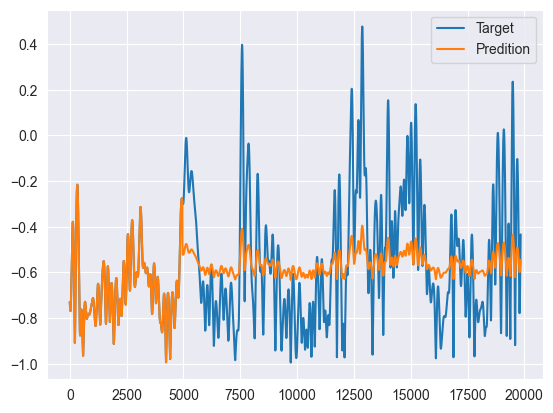

In [140]:
plt.plot(np.vstack((y_train.detach().numpy(),y_test.detach().numpy()))[int(len(x)*0.6):],label='Target') 
plt.plot(np.vstack((y_train.detach().numpy(),model(x_test).detach().numpy()))[int(len(x)*0.6):],label='Predition')
plt.title('')
#plt.axvline(int(len(x)*0.8)) 
plt.legend()

In [141]:
train_loss2, test_loss2 = train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               epochs=200)

  3%|▎         | 6/200 [00:01<00:34,  5.66it/s]

Epoch :0.025    Train Loss :0.05168122798204422    Test Loss :0.05360059067606926


  6%|▌         | 11/200 [00:02<00:34,  5.47it/s]

Epoch :0.05    Train Loss :0.0463518463075161    Test Loss :0.04778962582349777


  8%|▊         | 16/200 [00:02<00:28,  6.51it/s]

Epoch :0.075    Train Loss :0.040156759321689606    Test Loss :0.041059739887714386


 10%|█         | 21/200 [00:03<00:28,  6.31it/s]

Epoch :0.1    Train Loss :0.0331132709980011    Test Loss :0.03342152386903763


 13%|█▎        | 26/200 [00:04<00:27,  6.38it/s]

Epoch :0.125    Train Loss :0.02539699897170067    Test Loss :0.025119613856077194


 16%|█▌        | 31/200 [00:05<00:27,  6.12it/s]

Epoch :0.15    Train Loss :0.01744338870048523    Test Loss :0.016656743362545967


 18%|█▊        | 36/200 [00:05<00:25,  6.49it/s]

Epoch :0.175    Train Loss :0.010030606761574745    Test Loss :0.008949684910476208


 20%|██        | 41/200 [00:06<00:23,  6.84it/s]

Epoch :0.2    Train Loss :0.004220833070576191    Test Loss :0.003201177576556802


 23%|██▎       | 46/200 [00:07<00:24,  6.20it/s]

Epoch :0.225    Train Loss :0.0009589432738721371    Test Loss :0.00039804703556001186


 26%|██▌       | 51/200 [00:08<00:23,  6.33it/s]

Epoch :0.25    Train Loss :0.00026209844509139657    Test Loss :0.00028438083245418966


 28%|██▊       | 56/200 [00:09<00:21,  6.67it/s]

Epoch :0.275    Train Loss :0.0007611214532516897    Test Loss :0.0010396507568657398


 30%|███       | 61/200 [00:09<00:21,  6.58it/s]

Epoch :0.3    Train Loss :0.0009358492097817361    Test Loss :0.0011034227209165692


 33%|███▎      | 66/200 [00:10<00:19,  6.88it/s]

Epoch :0.325    Train Loss :0.0006127140368334949    Test Loss :0.0006111887632869184


 36%|███▌      | 71/200 [00:11<00:19,  6.71it/s]

Epoch :0.35    Train Loss :0.0003103473864030093    Test Loss :0.00021963250765111297


 38%|███▊      | 76/200 [00:12<00:18,  6.78it/s]

Epoch :0.375    Train Loss :0.0002251190016977489    Test Loss :9.466326446272433e-05


 40%|████      | 81/200 [00:12<00:17,  6.88it/s]

Epoch :0.4    Train Loss :0.0002482732816133648    Test Loss :9.440042776986957e-05


 43%|████▎     | 86/200 [00:13<00:16,  6.87it/s]

Epoch :0.425    Train Loss :0.00026494526537135243    Test Loss :0.0001008942854241468


 46%|████▌     | 91/200 [00:14<00:15,  6.99it/s]

Epoch :0.45    Train Loss :0.00025021634064614773    Test Loss :9.272431634599343e-05


 48%|████▊     | 96/200 [00:14<00:15,  6.83it/s]

Epoch :0.475    Train Loss :0.00022717771935276687    Test Loss :8.888093725545332e-05


 50%|█████     | 101/200 [00:15<00:14,  6.86it/s]

Epoch :0.5    Train Loss :0.00021483114687725902    Test Loss :9.810503979679197e-05


 53%|█████▎    | 106/200 [00:16<00:13,  6.88it/s]

Epoch :0.525    Train Loss :0.0002128348860424012    Test Loss :0.00011125220771646127


 56%|█████▌    | 111/200 [00:17<00:12,  7.12it/s]

Epoch :0.55    Train Loss :0.00021289112919475883    Test Loss :0.00011741839989554137


 58%|█████▊    | 116/200 [00:17<00:12,  6.53it/s]

Epoch :0.575    Train Loss :0.0002108247863361612    Test Loss :0.00011487187293823808


 60%|██████    | 121/200 [00:18<00:12,  6.39it/s]

Epoch :0.6    Train Loss :0.00020763225620612502    Test Loss :0.00010842089977813885


 63%|██████▎   | 126/200 [00:19<00:11,  6.62it/s]

Epoch :0.625    Train Loss :0.000205068732611835    Test Loss :0.00010266972822137177


 66%|██████▌   | 131/200 [00:20<00:10,  6.73it/s]

Epoch :0.65    Train Loss :0.00020336295710876584    Test Loss :9.931428940035403e-05


 68%|██████▊   | 136/200 [00:20<00:10,  6.10it/s]

Epoch :0.675    Train Loss :0.00020190524810459465    Test Loss :9.813713404582813e-05


 70%|███████   | 141/200 [00:21<00:08,  6.87it/s]

Epoch :0.7    Train Loss :0.00020033505279570818    Test Loss :9.843674342846498e-05


 73%|███████▎  | 146/200 [00:22<00:07,  6.99it/s]

Epoch :0.725    Train Loss :0.00019870825053658336    Test Loss :9.952478285413235e-05


 76%|███████▌  | 151/200 [00:23<00:07,  6.77it/s]

Epoch :0.75    Train Loss :0.00019716158567462116    Test Loss :0.00010075569298351184


 78%|███████▊  | 156/200 [00:23<00:07,  5.83it/s]

Epoch :0.775    Train Loss :0.00019571407756302506    Test Loss :0.00010162947000935674


 80%|████████  | 161/200 [00:24<00:05,  6.63it/s]

Epoch :0.8    Train Loss :0.00019431652617640793    Test Loss :0.00010193746857112274


 83%|████████▎ | 166/200 [00:25<00:04,  7.13it/s]

Epoch :0.825    Train Loss :0.00019294042431283742    Test Loss :0.00010177167860092595


 86%|████████▌ | 171/200 [00:26<00:04,  6.97it/s]

Epoch :0.85    Train Loss :0.0001915909379022196    Test Loss :0.00010137761273654178


 88%|████████▊ | 176/200 [00:26<00:03,  6.61it/s]

Epoch :0.875    Train Loss :0.00019027663802262396    Test Loss :0.00010098588973050937


 90%|█████████ | 181/200 [00:27<00:03,  6.24it/s]

Epoch :0.9    Train Loss :0.0001889970008051023    Test Loss :0.00010072780423797667


 93%|█████████▎| 186/200 [00:28<00:02,  6.78it/s]

Epoch :0.925    Train Loss :0.00018774646741803735    Test Loss :0.00010062683577416465


 96%|█████████▌| 191/200 [00:29<00:01,  6.70it/s]

Epoch :0.95    Train Loss :0.00018652201106306165    Test Loss :0.00010063736408483237


 98%|█████████▊| 196/200 [00:30<00:00,  6.77it/s]

Epoch :0.975    Train Loss :0.00018532323883846402    Test Loss :0.00010069053678307682


100%|██████████| 200/200 [00:30<00:00,  6.54it/s]

Epoch :1.0    Train Loss :0.00018414964142721146    Test Loss :0.00010072517761727795


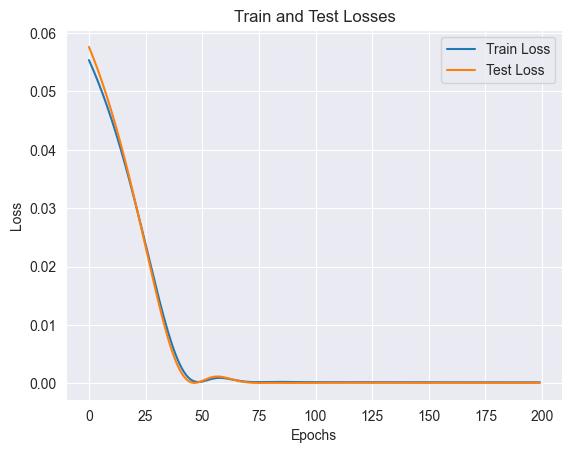

In [142]:
plt.plot(train_loss2, label='Train Loss')
plt.plot(test_loss2, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()


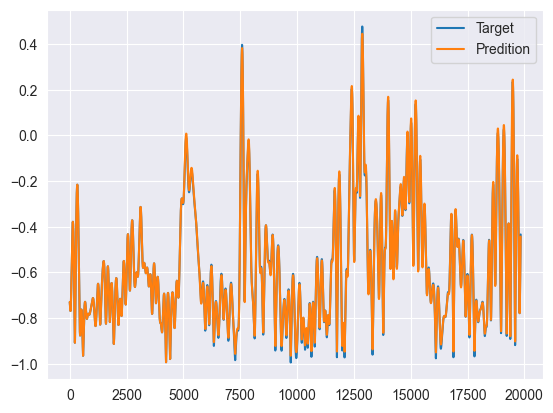

In [145]:
plt.plot(np.vstack((y_train.detach().numpy(),y_test.detach().numpy()))[int(len(x)*0.6):],label='Target') 
plt.plot(np.vstack((y_train.detach().numpy(),model(x_test).detach().numpy()))[int(len(x)*0.6):],label='Predition') 
#plt.axvline(int(len(x)*0.8)) 
plt.legend()